# Analysis of clinical variatns of ORC1 protein

In [1]:
# Import libraries
from clinvar_functions import *
import pandas as pd
import matplotlib.pyplot as plt

## ORC1 regions

In [2]:
# List of intervals for particular feature

#LLPS = [(360, 382), (412, 476), (577, 636), (677, 729), (757, 816)] # Chinees paper
#IDR_total = [(183, 476)] # Chinees paper
#G4_RNA = [(413, 511)] # Hoshina paper
#CDCD6=[(180, 240)] # CDC6 paper
#BP=[(354, 368), (378, 392)] # CDC6 paper
IDR = [(183, 511)]
RBD = [(413, 511)]

# Positions
IDR_pos = generate_list(IDR)
RBD_pos = generate_list(RBD)
# G4_RNA_positions = generate_list(G4_RNA)
# LLPS_positions = generate_list(LLPS)
# CDCD6_positions = generate_list(CDCD6)
# BP_positions = generate_list(BP)

## Read data

In [3]:
# Set option to display all rows and columns
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

# Read dataframe
df = pd.read_csv('./data/clinvar_result.csv', sep = "\t")
df = df[df['Gene(s)'] == 'ORC1'] # save only ORC1 gene - delete 7 records
df.shape

(333, 25)

In [4]:
columns = ['Gene(s)', "Variant type", 'Molecular consequence', 'Germline classification', 'Germline review status',\
           'Somatic clinical impact', 'Oncogenicity classification', 'Oncogenicity review status']
for col in columns:
    print(col, set(df[col]))

Gene(s) {'ORC1'}
Variant type {'Haplotype', 'Microsatellite', 'Deletion', 'Indel', 'Duplication', 'single nucleotide variant'}
Molecular consequence {nan, 'intron variant', 'frameshift variant|missense variant', 'inframe_deletion', 'inframe_deletion|intron variant', '3 prime UTR variant', 'missense variant', 'splice acceptor variant', 'nonsense', 'synonymous variant|intron variant', 'synonymous variant', 'frameshift variant', 'splice donor variant'}
Germline classification {'Pathogenic', 'Likely benign', 'Benign/Likely benign', 'no classification for the single variant', 'Uncertain significance', 'Benign', 'Likely pathogenic', 'Pathogenic/Likely pathogenic', 'Conflicting classifications of pathogenicity'}
Germline review status {'criteria provided, single submitter', 'criteria provided, conflicting classifications', 'criteria provided, multiple submitters, no conflicts', 'no assertion criteria provided', 'no classification for the single variant'}
Somatic clinical impact {nan, 'no clas

## Look at the different columns of df

In [5]:
df["Condition(s)"].value_counts()

Condition(s)
not provided                                                                200
Meier-Gorlin syndrome 1                                                      30
Inborn genetic diseases                                                      30
Meier-Gorlin syndrome 1|not provided                                          8
not provided|Meier-Gorlin syndrome 1                                          8
not provided|Inborn genetic diseases                                          7
Inborn genetic diseases|not provided                                          5
not specified                                                                 5
not provided|not specified|Meier-Gorlin syndrome 1                            4
ORC1-related disorder|not provided                                            4
not provided|not specified                                                    3
not specified|not provided|Meier-Gorlin syndrome 1                            3
Meier-Gorlin syndrome 1|not

In [6]:
df["Germline classification"].value_counts()

Germline classification
Uncertain significance                          155
Likely benign                                    97
Benign                                           24
Conflicting classifications of pathogenicity     19
Pathogenic                                       16
Likely pathogenic                                10
Benign/Likely benign                              9
no classification for the single variant          2
Pathogenic/Likely pathogenic                      1
Name: count, dtype: int64

In [7]:
df['Germline review status'].value_counts()

Germline review status
criteria provided, single submitter                     245
criteria provided, multiple submitters, no conflicts     61
criteria provided, conflicting classifications           19
no assertion criteria provided                            6
no classification for the single variant                  2
Name: count, dtype: int64

In [8]:
df['Germline classification'].value_counts()

Germline classification
Uncertain significance                          155
Likely benign                                    97
Benign                                           24
Conflicting classifications of pathogenicity     19
Pathogenic                                       16
Likely pathogenic                                10
Benign/Likely benign                              9
no classification for the single variant          2
Pathogenic/Likely pathogenic                      1
Name: count, dtype: int64

In [9]:
df['Molecular consequence'].value_counts()

Molecular consequence
missense variant                       172
synonymous variant                      77
intron variant                          53
frameshift variant                      10
splice acceptor variant                  6
nonsense                                 4
3 prime UTR variant                      3
synonymous variant|intron variant        2
splice donor variant                     2
frameshift variant|missense variant      1
inframe_deletion|intron variant          1
inframe_deletion                         1
Name: count, dtype: int64

## Get list of transcript IDs

In [10]:
IDs = df['Name'].apply(lambda x: x.split(":")[0])
IDs.value_counts()

Name
NM_004153.4(ORC1)       332
NM_001190818.1(ORC1)      1
Name: count, dtype: int64

## Add new column: Condition_new

In [11]:
df['Condition_new'] = df['Condition(s)'].map(rename_condition, na_action='ignore')

In [12]:
df['Condition_new'].value_counts()

Condition_new
not provided                        211
Meier-Gorlin syndrome 1 probably     42
Meier-Gorlin syndrome 1              30
Inborn genetic diseases              30
Inborn genetic diseases probably     12
ORC1-related disorder probably        6
Name: count, dtype: int64

# Non-coding mutations

In [13]:
sum(df["Protein change"].isna()) # no protein change - how many mutations?

145

In [14]:
len(df["Protein change"]) # all variants - how many?

333

In [15]:
# Making a subset of variants that are not affected protein level
noncoding = df[df["Protein change"].isna()]

In [16]:
noncoding['Condition_new'].value_counts()

Condition_new
not provided                        115
Meier-Gorlin syndrome 1 probably     15
Meier-Gorlin syndrome 1               9
ORC1-related disorder probably        4
Inborn genetic diseases               1
Inborn genetic diseases probably      1
Name: count, dtype: int64

In [17]:
noncoding[noncoding['Condition_new'] == 'Meier-Gorlin syndrome 1'].groupby('Germline review status').size()

Germline review status
criteria provided, single submitter    8
no assertion criteria provided         1
dtype: int64

In [18]:
noncoding[noncoding['Condition_new'] == 'Meier-Gorlin syndrome 1 probably'].groupby('Germline review status').size()

Germline review status
criteria provided, conflicting classifications          8
criteria provided, multiple submitters, no conflicts    7
dtype: int64

# Non-coding variants visualization

List of Exons of ORC1 (file hg38_dna range=chr1:52372829-52404423):
exon          	1..547        
exon          	1982..2069    
exon          	2602..2771    
exon          	8814..8933    
exon          	10.592..10.741
exon          	11.002..11.109
exon          	11.722..11.893
exon          	12.333..12.434
exon          	13.024..13.121
exon          	15.614..15.809
exon          	16.389..16.493
exon          	20.615..20.975
exon          	23.218..23.536
exon          	24.857..25.035
exon          	28.534..28.661
exon          	29.301..29.400
exon          	31.418..31.595

List of regulation elements (file hg38_dna range=chr1:52372829-52404423):
enhancer_distal 12585...12893
enhancer_proximal 30091..30367
enhancer_proximal 30826..31175
enhancer_proximal 31239..31442
promoter (partial) 31531..31595

Gene length: 31595 bp
Positions: 52372829 - 52404423

In [19]:
# Subset of data from noncoding dataframe

# Filter the data for multiple conditions
MGS_non_coding_muts = noncoding[
    (noncoding['Condition_new'] == 'Meier-Gorlin syndrome 1') &
    (noncoding['Germline review status'] == 'criteria provided, single submitter')
][['GRCh38Location', 'Name', 'Condition_new', 'Accession', "Germline classification", 'Molecular consequence']]

# Filter the data for multiple conditions
MGS_probable_non_coding_muts = noncoding[
    (noncoding['Condition_new'] == 'Meier-Gorlin syndrome 1 probably') &
    (noncoding['Germline review status'] == 'criteria provided, multiple submitters, no conflicts')
][['GRCh38Location', 'Name', 'Condition_new', 'Accession', "Germline classification", 'Molecular consequence']]

# Create new column New_location
MGS_non_coding_muts["New_location"] = MGS_non_coding_muts['GRCh38Location'].apply(parse_location).astype(int).apply(lambda x: adjust_location(x, 52372828))
MGS_probable_non_coding_muts["New_location"] = MGS_probable_non_coding_muts['GRCh38Location'].apply(parse_location).astype(int).apply(lambda x: adjust_location(x, 52372828))

# Create new column New_name

MGS_non_coding_muts["New_name"] = MGS_non_coding_muts['Name'].apply(lambda x: x.split(":")[1])
MGS_probable_non_coding_muts["New_name"] = MGS_probable_non_coding_muts['Name'].apply(lambda x: x.split(":")[1])

In [20]:
MGS_non_coding_muts

,GRCh38Location,Name,Condition_new,Accession,Germline classification,Molecular consequence,New_location,New_name
0,52369376 - 52373623,NM_001190818.1(ORC1):c.2392-249_*3804del,Meier-Gorlin syndrome 1,VCV001173067,Pathogenic,NaN,795,c.2392-249_*3804del
2,52372955,NM_004153.4(ORC1):c.*226G>C,Meier-Gorlin syndrome 1,VCV000297575,Uncertain significance,3 prime UTR variant,127,c.*226G>C
3,52373087,NM_004153.4(ORC1):c.*94C>T,Meier-Gorlin syndrome 1,VCV000297576,Uncertain significance,3 prime UTR variant,259,c.*94C>T
32,52373349,NM_004153.4(ORC1):c.2418C>T (p.Cys806=),Meier-Gorlin syndrome 1,VCV000874893,Uncertain significance,synonymous variant,521,c.2418C>T (p.Cys806=)
182,52388541,NM_004153.4(ORC1):c.1284A>C (p.Thr428=),Meier-Gorlin syndrome 1,VCV000297584,Uncertain significance,synonymous variant,15713,c.1284A>C (p.Thr428=)
277,52396332,NM_004153.4(ORC1):c.435G>A (p.Pro145=),Meier-Gorlin syndrome 1,VCV000297587,Uncertain significance,synonymous variant,23504,c.435G>A (p.Pro145=)
280,52396366,NM_004153.4(ORC1):c.403-2A>C,Meier-Gorlin syndrome 1,VCV001323388,Pathogenic,splice acceptor variant,23538,c.403-2A>C
332,52402240,NM_004153.4(ORC1):c.-5-12A>T,Meier-Gorlin syndrome 1,VCV000875878,Uncertain significance,intron variant,29412,c.-5-12A>T


In [21]:
MGS_probable_non_coding_muts

,GRCh38Location,Name,Condition_new,Accession,Germline classification,Molecular consequence,New_location,New_name
1,52372950,NM_004153.4(ORC1):c.*231C>T,Meier-Gorlin syndrome 1 probably,VCV000297574,Benign,3 prime UTR variant,122,c.*231C>T
30,52373340,NM_004153.4(ORC1):c.2427G>A (p.Glu809=),Meier-Gorlin syndrome 1 probably,VCV000129859,Benign,synonymous variant,512,c.2427G>A (p.Glu809=)
61,52375507,NM_004153.4(ORC1):c.2226C>A (p.Ser742=),Meier-Gorlin syndrome 1 probably,VCV000436112,Benign/Likely benign,synonymous variant,2679,c.2226C>A (p.Ser742=)
128,52384725,NM_004153.4(ORC1):c.1584-4C>G,Meier-Gorlin syndrome 1 probably,VCV000297582,Benign,intron variant,11897,c.1584-4C>G
168,52388442,NM_004153.4(ORC1):c.1383T>C (p.Ser461=),Meier-Gorlin syndrome 1 probably,VCV000876821,Uncertain significance,synonymous variant|intron variant,15614,c.1383T>C (p.Ser461=)
284,52397673,NM_004153.4(ORC1):c.402+12C>T,Meier-Gorlin syndrome 1 probably,VCV000874947,Benign/Likely benign,intron variant,24845,c.402+12C>T
314,52401396,NM_004153.4(ORC1):c.189G>T (p.Pro63=),Meier-Gorlin syndrome 1 probably,VCV000874949,Benign/Likely benign,synonymous variant,28568,c.189G>T (p.Pro63=)


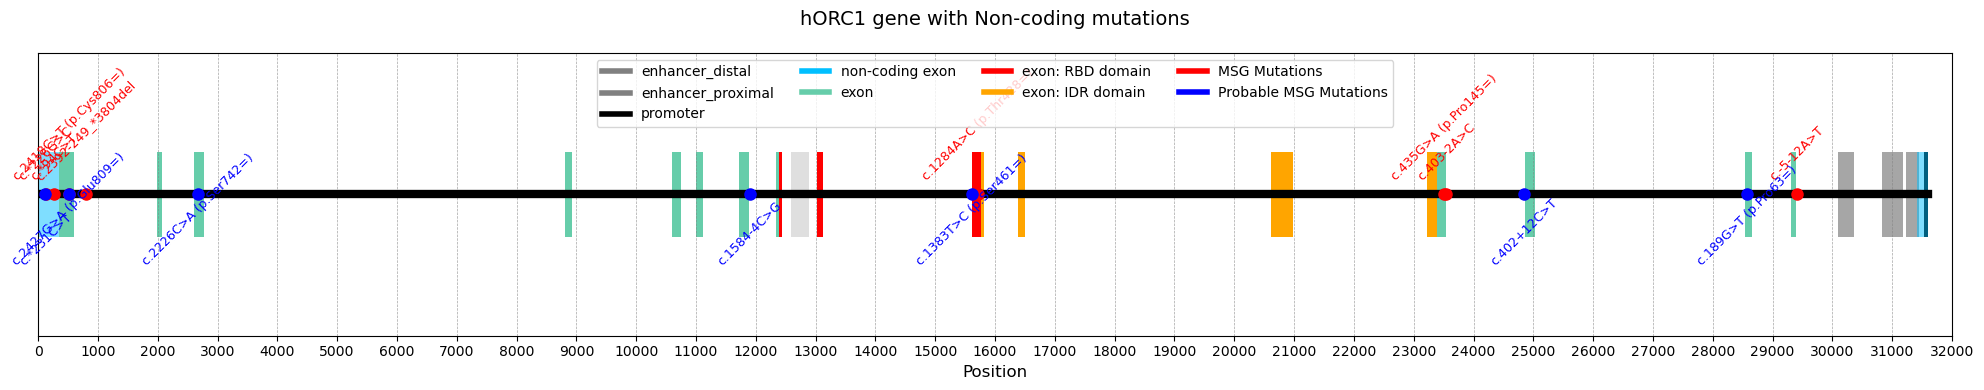

In [22]:
# Define protein information
protein_length = 31595  # Gene length
domains = [
    # regulatory elements
    {"name": "enhancer_distal", "start": 12585, "end": 12893, "color": "grey", "alpha": 0.25},
    {"name": "enhancer_proximal", "start": 30091, "end": 30367, "color": "grey", "alpha": 0.7},
    {"name": "enhancer_proximal", "start": 30826, "end": 31175, "color": "grey", "alpha": 0.7},
    {"name": "enhancer_proximal", "start": 31239, "end": 31442, "color": "grey", "alpha": 0.7},
    {"name": "promoter", "start": 31531, "end": 31595, "color": "black", "alpha": 1},

    {"name": "non-coding exon", "start": 1, "end": 352, "color": "deepskyblue", "alpha": 0.5},
    {"name": "exon", "start": 353, "end": 597, "color": "mediumaquamarine", "alpha": 1},

    {"name": "exon", "start": 1982, "end": 2069, "color": "mediumaquamarine", "alpha": 1},
    {"name": "exon", "start": 2602, "end": 2771, "color": "mediumaquamarine", "alpha": 1},
    {"name": "exon", "start": 8814, "end": 8933, "color": "mediumaquamarine", "alpha": 1},
    {"name": "exon", "start": 10592, "end": 10741, "color": "mediumaquamarine", "alpha": 1},
    {"name": "exon", "start": 11002, "end": 11109, "color": "mediumaquamarine", "alpha": 1},
    {"name": "exon", "start": 11722, "end": 11893, "color": "mediumaquamarine", "alpha": 1},

    # IDR end
    {"name": "exon", "start": 12333, "end": 12382, "color": "mediumaquamarine", "alpha": 1},
    {"name": "exon: RBD domain", "start": 12383, "end": 12434, "color": "red", "alpha": 1},

    {"name": "exon: RBD domain", "start": 13024, "end": 13121, "color": "red", "alpha": 1},

    # RBD start
    {"name": "exon: IDR domain", "start": 15760, "end": 15809, "color": "orange", "alpha": 1},
    {"name": "exon: IDR domain", "start": 15614, "end": 15759, "color": "red", "alpha": 1},

    {"name": "exon: IDR domain", "start": 16389, "end": 16493, "color": "orange", "alpha": 1},
    {"name": "exon: IDR domain", "start": 20615, "end": 20975, "color": "orange", "alpha": 1},
    
    # IDR start
    {"name": "exon: IDR domain", "start": 23218, "end": 23392, "color": "orange", "alpha": 1},
    {"name": "exon", "start": 23393, "end": 23536, "color": "mediumaquamarine", "alpha": 1},

    {"name": "exon", "start": 24857, "end": 25035, "color": "mediumaquamarine", "alpha": 1},
    {"name": "exon", "start": 28534, "end": 28661, "color": "mediumaquamarine", "alpha": 1},

    {"name": "exon", "start": 29301, "end": 29396, "color": "mediumaquamarine", "alpha": 1},
    {"name": "non-coding exon", "start": 29397, "end": 29400, "color": "deepskyblue", "alpha": 1},

    {"name": "exon", "start": 31418, "end": 31595, "color": "deepskyblue", "alpha": 0.5}
]


# Create the figure
fig, ax = plt.subplots(figsize=(20, 4))

# Draw the protein backbone
ax.plot([0, protein_length], [0.5, 0.5], color="black", lw=6, label="Protein Backbone")

# Track unique labels for the legend
unique_labels = {}

# Draw the domains with labels
for domain in domains:
    label = f"{domain['name']}"
    if label not in unique_labels:
        unique_labels[label] = domain["color"]
    ax.barh(0.5, domain["end"] - domain["start"], left=domain["start"], height=0.3,
            color=domain["color"], alpha=domain["alpha"], label=None)  # Add label only for legend
    
# Plot mutations
for _, mutation in MGS_non_coding_muts.iterrows():
    ax.plot(
        mutation["New_location"],
        0.5,
        marker="o",
        color="red",
        markersize=8,
        label="Mutation" if _ == 0 else ""
    )
    ax.text(
        mutation["New_location"],
        0.55,
        mutation["New_name"],
        ha="center",
        fontsize=9,
        rotation=45,
        color="red"
    )

unique_labels["MSG Mutations"] = "red"
unique_labels["Probable MSG Mutations"] = "blue"

# Plot mutations
for _, mutation in MGS_probable_non_coding_muts.iterrows():
    ax.plot(
        mutation["New_location"],
        0.5,
        marker="o",
        color="blue",
        markersize=8,
        label="Mutation" if _ == 0 else ""
    )
    ax.text(
        mutation["New_location"],
        0.25,
        mutation["New_name"],
        ha="center",
        fontsize=9,
        rotation=45,
        color="blue"
    )



# Add the unique legend
ax.legend(handles=[plt.Line2D([0], [0], color=color, lw=4, label=label) for label, color in unique_labels.items()],
          loc="upper center", ncol=4, frameon=True, fontsize=10)

# Add gridlines for alignment
ax.grid(axis="x", color="gray", linestyle="--", linewidth=0.5, alpha=0.7)

# Add labels and title
ax.set_xlim(0, protein_length)
ax.set_ylim(0, 1)
ax.set_xticks(range(0, protein_length + 1000, 1000))
ax.set_yticks([])
ax.set_xlabel("Position", fontsize=12)
ax.set_title("hORC1 gene with Non-coding mutations", fontsize=14, pad=20)

# Show the plot
plt.tight_layout()
plt.show()


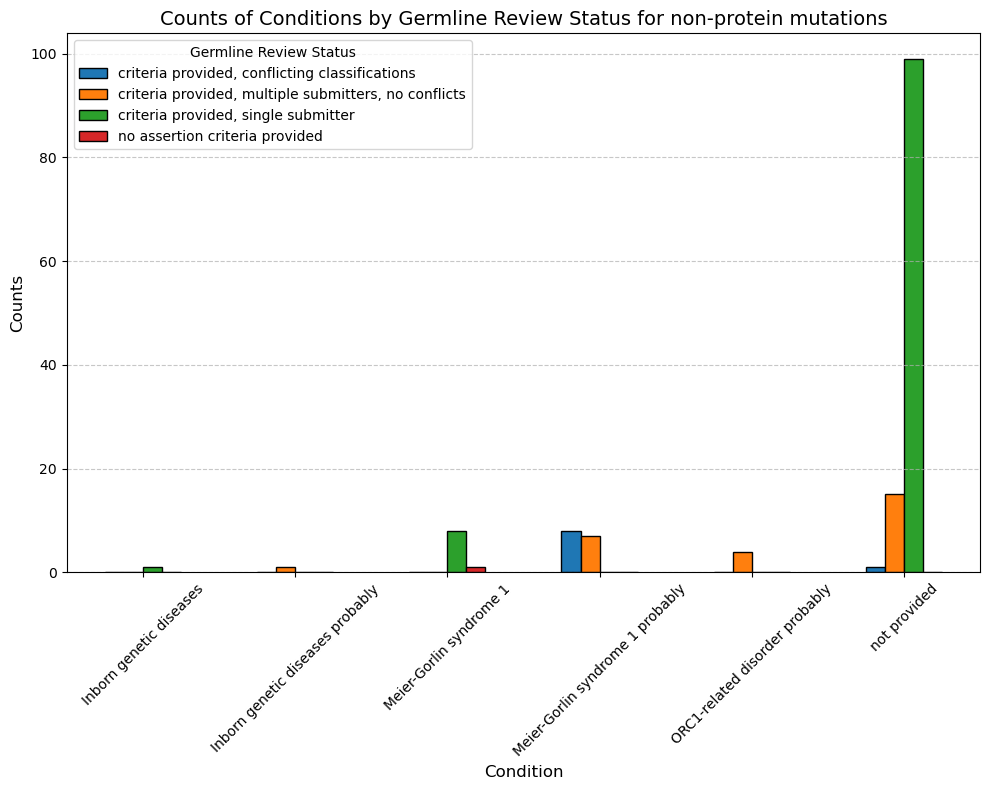

In [23]:
# Data
grouped_counts = noncoding.groupby("Germline review status")["Condition_new"].value_counts()
plot_data = grouped_counts.reset_index(name="Counts")
plot_data

# Pivot the data for better visualization
pivot_data = plot_data.pivot(index="Condition_new", columns="Germline review status", values="Counts")

# Plot as a bar chart
pivot_data.plot(kind="bar", figsize=(10, 8), edgecolor="black")

plt.title("Counts of Conditions by Germline Review Status for non-protein mutations", fontsize=14)
plt.xlabel("Condition", fontsize=12)
plt.ylabel("Counts", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Germline Review Status")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

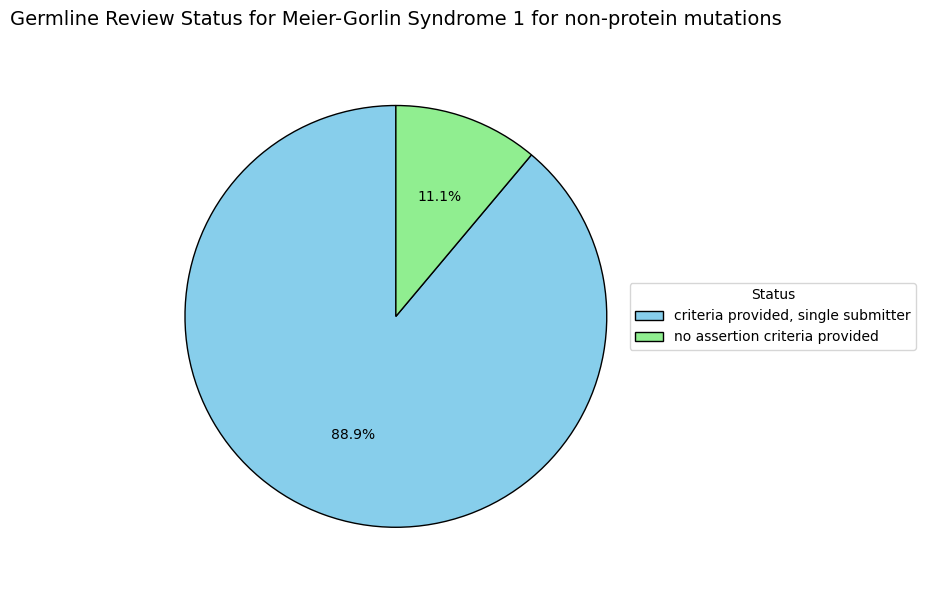

In [24]:
# Filter the data for the specific condition
filtered_data = noncoding['Germline review status'][df["Condition_new"] =="Meier-Gorlin syndrome 1"]
# Count the occurrences of each status
status_counts = filtered_data.value_counts()

# Count the occurrences of each status
status_counts = filtered_data.value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 6))
pie_chart = status_counts.plot.pie(
    labels=None,
    autopct='%1.1f%%',  # Show percentages
    startangle=90,      # Rotate start angle
    colors=['skyblue', 'lightgreen', 'orange'],  # Optional: specify colors
    wedgeprops={'edgecolor': 'black'},  # Add edge color
    title="Germline Review Status for Meier-Gorlin Syndrome 1 for non-protein mutations"
)
# Add a centered title
plt.title(
    "Germline Review Status for Meier-Gorlin Syndrome 1 for non-protein mutations", 
    loc="center",          # Explicitly center the title
    fontsize=14,           # Adjust font size for visibility
    pad=20                 # Add padding between the title and the chart
)

# Add a legend at the center right
plt.legend(
    labels=status_counts.index,  # Use the status names as labels
    title="Status",              # Add a title to the legend
    loc="center right",          # Position the legend at the center-right
    bbox_to_anchor=(1.50, 0.5),  # Offset for better alignment
)

plt.ylabel("")  # Remove default y-axis label
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

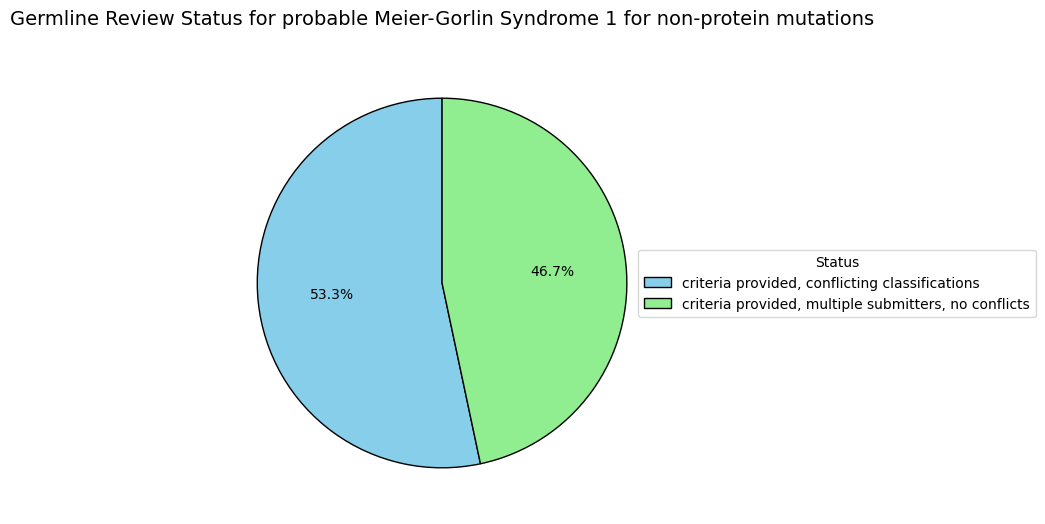

In [25]:
# Filter the data for the specific condition
filtered_data = noncoding['Germline review status'][df["Condition_new"] =="Meier-Gorlin syndrome 1 probably"]
# Count the occurrences of each status
status_counts = filtered_data.value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 6))
status_counts.plot.pie(
    labels=None,
    autopct='%1.1f%%',  # Show percentages
    startangle=90,      # Rotate start angle
    colors=['skyblue', 'lightgreen', 'orange'],  # Optional: specify colors
    wedgeprops={'edgecolor': 'black'},  # Add edge color
    title="Germline Review Status for probable Meier-Gorlin Syndrome 1"
)
# Add a centered title
plt.title(
    "Germline Review Status for probable Meier-Gorlin Syndrome 1 for non-protein mutations", 
    ha="center",          # Explicitly center the title
    fontsize=14,           # Adjust font size for visibility
    pad=20
    )

# Add a legend at the center right
plt.legend(
    labels=status_counts.index,  # Use the status names as labels
    title="Status",              # Add a title to the legend
    loc="center right",          # Position the legend at the center-right
    bbox_to_anchor=(1.80, 0.5),  # Offset for better alignment
)

plt.ylabel("")  # Remove default y-axis label
plt.show()

# Visualisation

## Analyse Germline review status

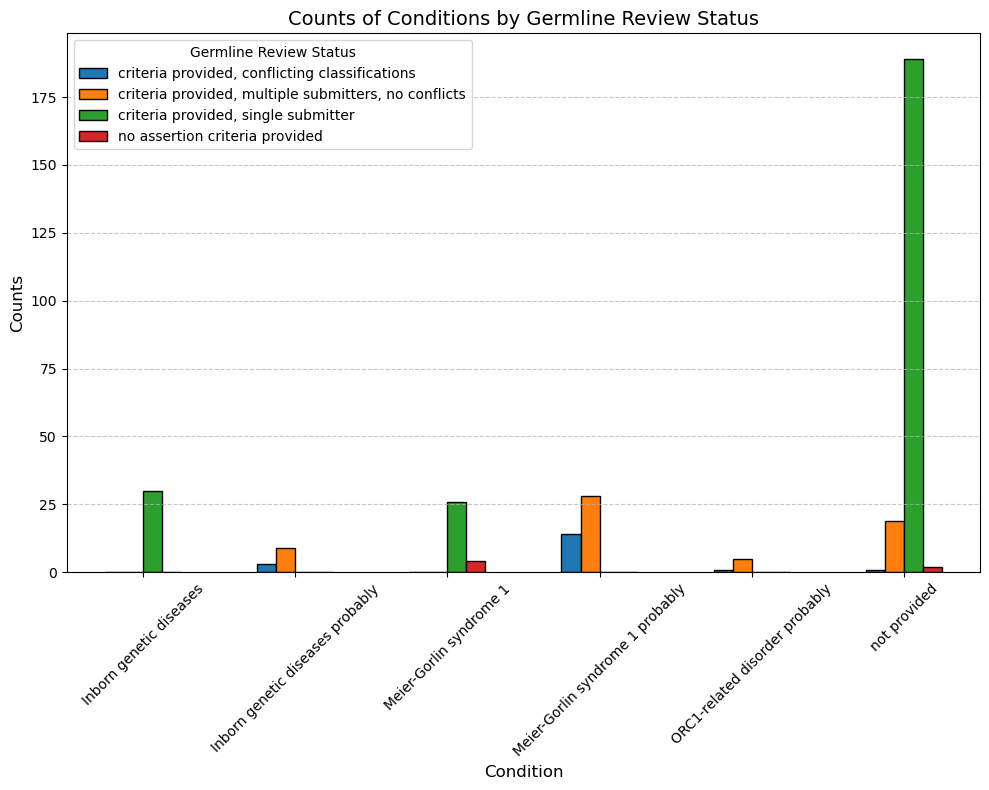

In [26]:
# Data
grouped_counts = df.groupby("Germline review status")["Condition_new"].value_counts()
plot_data = grouped_counts.reset_index(name="Counts")
plot_data

# Pivot the data for better visualization
pivot_data = plot_data.pivot(index="Condition_new", columns="Germline review status", values="Counts")

# Plot as a bar chart
pivot_data.plot(kind="bar", figsize=(10, 8), edgecolor="black")

plt.title("Counts of Conditions by Germline Review Status", fontsize=14)
plt.xlabel("Condition", fontsize=12)
plt.ylabel("Counts", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Germline Review Status")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

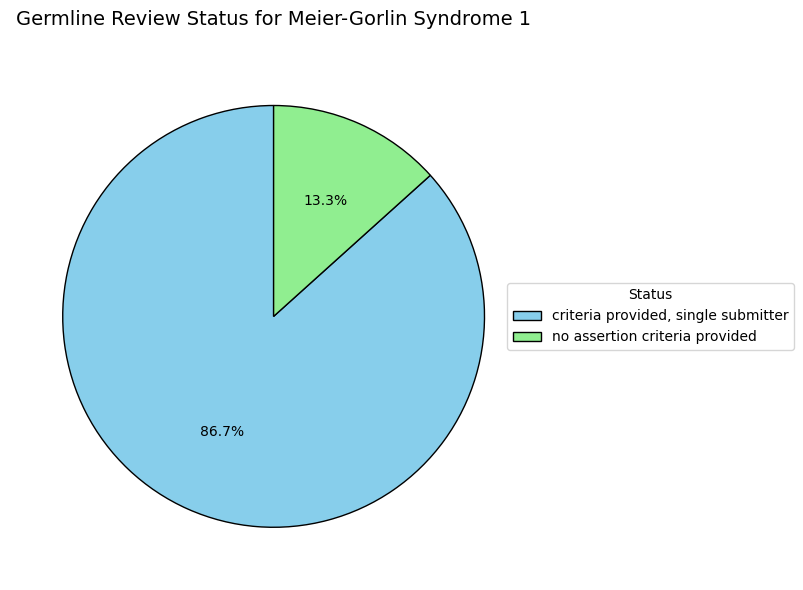

In [27]:
# Filter the data for the specific condition
filtered_data = df['Germline review status'][df["Condition_new"] =="Meier-Gorlin syndrome 1"]
# Count the occurrences of each status
status_counts = filtered_data.value_counts()

# Count the occurrences of each status
status_counts = filtered_data.value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 6))
pie_chart = status_counts.plot.pie(
    labels=None,
    autopct='%1.1f%%',  # Show percentages
    startangle=90,      # Rotate start angle
    colors=['skyblue', 'lightgreen', 'orange'],  # Optional: specify colors
    wedgeprops={'edgecolor': 'black'},  # Add edge color
    title="Germline Review Status for Meier-Gorlin Syndrome 1"
)
# Add a centered title
plt.title(
    "Germline Review Status for Meier-Gorlin Syndrome 1", 
    loc="center",          # Explicitly center the title
    fontsize=14,           # Adjust font size for visibility
    pad=20                 # Add padding between the title and the chart
)

# Add a legend at the center right
plt.legend(
    labels=status_counts.index,  # Use the status names as labels
    title="Status",              # Add a title to the legend
    loc="center right",          # Position the legend at the center-right
    bbox_to_anchor=(1.50, 0.5),  # Offset for better alignment
)

plt.ylabel("")  # Remove default y-axis label
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

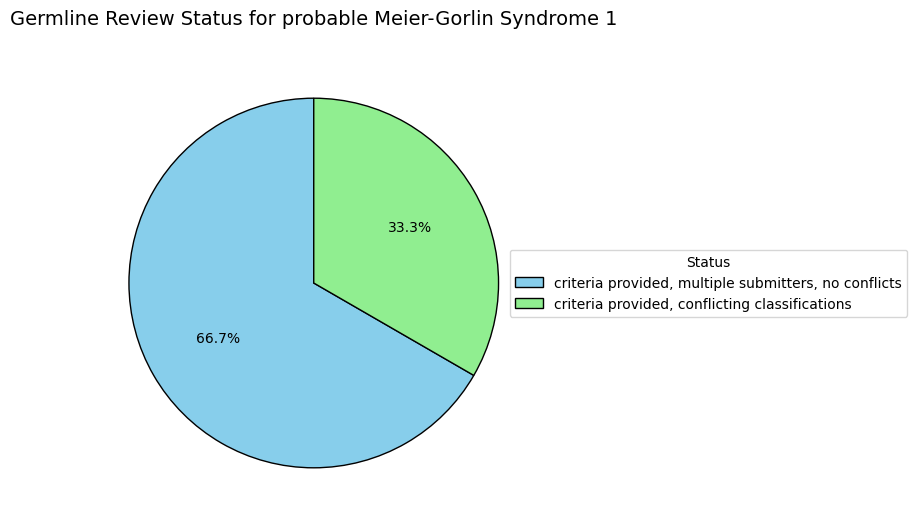

In [28]:
# Filter the data for the specific condition
filtered_data = df['Germline review status'][df["Condition_new"] =="Meier-Gorlin syndrome 1 probably"]
# Count the occurrences of each status
status_counts = filtered_data.value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 6))
status_counts.plot.pie(
    labels=None,
    autopct='%1.1f%%',  # Show percentages
    startangle=90,      # Rotate start angle
    colors=['skyblue', 'lightgreen', 'orange'],  # Optional: specify colors
    wedgeprops={'edgecolor': 'black'},  # Add edge color
    title="Germline Review Status for probable Meier-Gorlin Syndrome 1"
)
# Add a centered title
plt.title(
    "Germline Review Status for probable Meier-Gorlin Syndrome 1", 
    ha="center",          # Explicitly center the title
    fontsize=14,           # Adjust font size for visibility
    pad=20
    )

# Add a legend at the center right
plt.legend(
    labels=status_counts.index,  # Use the status names as labels
    title="Status",              # Add a title to the legend
    loc="center right",          # Position the legend at the center-right
    bbox_to_anchor=(1.80, 0.5),  # Offset for better alignment
)

plt.ylabel("")  # Remove default y-axis label
plt.show()

## Filtration: Meier-Gorlin syndrome 1 and probable Meier-Gorlin syndrome 1

In [29]:
# Keep only protein changes
df = df.dropna(subset=["Protein change"])

Mutations that change amino acids. The picture of protein with domains.
Filter mutations by the following rules:
1. Germline review status == "criteria provided, single submitter" OR "criteria provided, multiple submitters, no conflicts"
2. 'Germline classification' == Uncertain significance OR Likely pathogenic OR Pathogenic

In [114]:
# Dataset filtration
MSG = df[
    (df["Condition_new"] == "Meier-Gorlin syndrome 1") &
    (df["Germline review status"] == "criteria provided, single submitter")
]
MSG = MSG[(MSG['Germline classification'] != 'Benign') & (MSG['Germline classification'] !='Benign/Likely benign')]

MSG_probably = df[
    (df["Condition_new"] == "Meier-Gorlin syndrome 1 probably") &
    (df["Germline review status"] == "criteria provided, multiple submitters, no conflicts")
]
MSG_probably = MSG_probably[(MSG_probably['Germline classification'] != 'Benign') & (MSG_probably['Germline classification'] !='Benign/Likely benign')]

Top Variants with Strong Negative Effects - These mutations significantly reduce phase separation and RNA-binding ability:

A.174.V 0.64 [ 0.56, 0.72 ]
R.396.W 0.66 [ 0.52, 0.8 ]
A.372.V 0.76 [ 0.84, 0.68 ]
G.399.D 0.76 [ 0.92, 0.6 ]
R.549.C 0.98 [ 0.96, 1 ]

Top Variants with Strong Positive Effects - These mutations enhance phase separation and RNA-binding ability:

E.73.K 0.764706  [ 0.882353, 0.647059 ]
L.617.P 0.823529 [ 0.941176, 0.705882 ]
C.186.R 0.882352 [ 0.823529, 0.941176 ]
L.622.P 0.882353 [ 1, 0.764706 ]

In [116]:
# Prediction of top negatively affected on the LLPS and RNA binding mutations and positively affected ones.
negative_mutations = ['A174V', 'R396W', 'A372V', 'G399D', 'R549C']
positive_mutations = ['E73K', 'L617P', 'C186R', 'L622P']

# Create dictionary with mutations of visualization
mutations_MSG = create_mutation_dict(MSG)
mutations_MSG_probably = create_mutation_dict(MSG_probably)

# Make 4 extra list of dictionaly with mutations of interest
negative_mutations_MGS=[]
positive_mutations_MGS=[]
negative_mutations_MGS_probably=[]
positive_mutations_MGS_probably=[]

for di in mutations_MSG:
    if di['label'] in negative_mutations:
        new_mutant = {'position': di['position'], 'label':di['label']}
        negative_mutations_MGS.append(new_mutant)
        mutations_MSG.remove(new_mutant)
    if di['label'] in positive_mutations:
        new_mutant = {'position': di['position'], 'label':di['label']}
        positive_mutations_MGS.append(new_mutant)
        mutations_MSG.remove(new_mutant)

for di in mutations_MSG_probably:
    if di['label'] in negative_mutations:
        new_mutant = {'position': di['position'], 'label':di['label']}
        negative_mutations_MGS_probably.append(new_mutant)
        mutations_MSG_probably.remove(new_mutant)
    if di['label'] in positive_mutations:
       new_mutant = {'position': di['position'], 'label':di['label']}
       positive_mutations_MGS_probably.append(new_mutant)
       mutations_MSG_probably.remove(new_mutant)


Number of variats is 18
Number of variats is 10


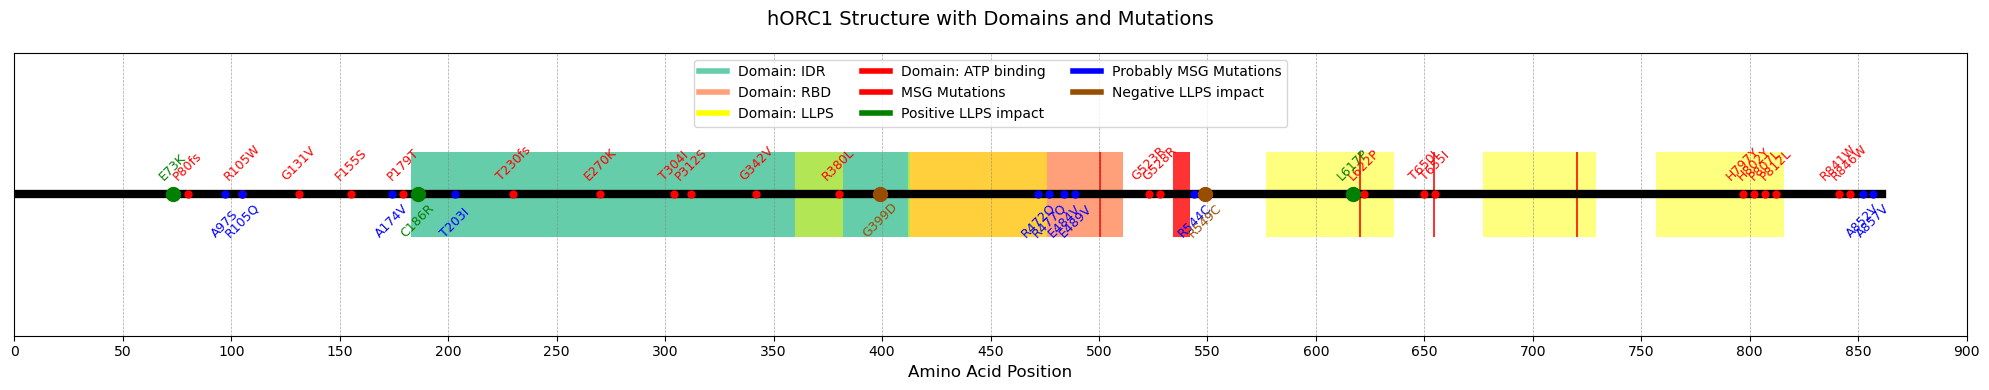

In [125]:
# Define protein information
protein_length = 861  # Protein length in amino acids
domains = [
    {"name": "IDR", "start": 183, "end": 413, "color": "mediumaquamarine", "alpha": 1},
    {"name": "RBD", "start": 413, "end": 511, "color": "lightsalmon", "alpha": 1},
    {"name": "LLPS", "start": 360, "end": 382, "color": "yellow", "alpha": 0.5},
    {"name": "LLPS", "start": 412, "end": 476, "color": "yellow", "alpha": 0.5},
    {"name": "LLPS", "start": 577, "end": 636, "color": "yellow", "alpha": 0.5},
    {"name": "LLPS", "start": 677, "end": 729, "color": "yellow", "alpha": 0.5},
    {"name": "LLPS", "start": 757, "end": 816, "color": "yellow", "alpha": 0.5},
    {"name": "ATP binding", "start": 534, "end": 542, "color": "red", "alpha": 0.8},
    {"name": "ATP binding", "start": 500, "end": 501, "color": "red", "alpha": 0.8},
    {"name": "ATP binding", "start": 620, "end": 621, "color": "red", "alpha": 0.8},
    {"name": "ATP binding", "start": 654, "end": 655, "color": "red", "alpha": 0.8},
    {"name": "ATP binding", "start": 720, "end": 721, "color": "red", "alpha": 0.8}


]


# Create the figure
fig, ax = plt.subplots(figsize=(20, 4))

# Draw the protein backbone
ax.plot([0, protein_length], [0.5, 0.5], color="black", lw=6, label="Protein Backbone")

# Track unique labels for the legend
unique_labels = {}

# Draw the domains with labels
for domain in domains:
    label = f"Domain: {domain['name']}"
    if label not in unique_labels:
        unique_labels[label] = domain["color"]
    ax.barh(0.5, domain["end"] - domain["start"], left=domain["start"], height=0.3,
            color=domain["color"], alpha=domain["alpha"], label=None)  # Add label only for legend

# Mark the mutations for MSG (above the backbone), neutral LLPS impact
for i, mutation in enumerate(mutations_MSG):
    if i == 0:
        unique_labels["MSG Mutations"] = "red"
    ax.plot(mutation["position"], 0.5, marker="o", color="red", markersize=5, label=None)
    ax.text(mutation["position"], 0.55, mutation["label"], ha="center", fontsize=9, rotation=45, color="red")

# MGS mutation, positive LLPS impact
for i, mutation in enumerate(positive_mutations_MGS):
    if i == 0:
        unique_labels["Positive LLPS impact"] = "green"
    ax.plot(mutation["position"], 0.5, marker="o", color="green", markersize=10, label=None)
    ax.text(mutation["position"], 0.55, mutation["label"], ha="center", fontsize=9, rotation=45, color="green")

# MGS mutation, negative LLPS impact
for i, mutation in enumerate(negative_mutations_MGS):
    if i == 0:
        unique_labels["Negative LLPS impact"] = "#994D00"
    ax.plot(mutation["position"], 0.5, marker="o", color="#994D00", markersize=10, label=None)
    ax.text(mutation["position"], 0.55, mutation["label"], ha="center", fontsize=9, rotation=45, color="#994D00")

# Mark the mutations for MSG_probably (below the backbone), neutral LLPS impact
for i, mutation in enumerate(mutations_MSG_probably):
    if i == 0:
        unique_labels["Probably MSG Mutations"] = "blue"
    ax.plot(mutation["position"], 0.5, marker="o", color="blue", markersize=5, label=None)
    ax.text(mutation["position"], 0.35, mutation["label"], ha="center", fontsize=9, rotation=45, color="blue")

# Probable MGS mutation, positive LLPS impact
for i, mutation in enumerate(positive_mutations_MGS_probably):
    if i == 0:
        unique_labels["Positive LLPS impact"] = "green"
    ax.plot(mutation["position"], 0.5, marker="o", color="green", markersize=10, label=None)
    ax.text(mutation["position"], 0.35, mutation["label"], ha="center", fontsize=9, rotation=45, color="green")

# Probable MGS mutation, negative LLPS impact
for i, mutation in enumerate(negative_mutations_MGS_probably):
    if i == 0:
        unique_labels["Negative LLPS impact"] = "#994D00"
    ax.plot(mutation["position"], 0.5, marker="o", color="#994D00", markersize=10, label=None)
    ax.text(mutation["position"], 0.35, mutation["label"], ha="center", fontsize=9, rotation=45, color="#994D00")

# Add the unique legend
ax.legend(handles=[plt.Line2D([0], [0], color=color, lw=4, label=label) for label, color in unique_labels.items()],
          loc="upper center", ncol=3, frameon=True, fontsize=10)

# Add gridlines for alignment
ax.grid(axis="x", color="gray", linestyle="--", linewidth=0.5, alpha=0.7)

# Add labels and title
ax.set_xlim(0, protein_length)
ax.set_ylim(0, 1)
ax.set_xticks(range(0, protein_length + 50, 50))
ax.set_yticks([])
ax.set_xlabel("Amino Acid Position", fontsize=12)
ax.set_title("hORC1 Structure with Domains and Mutations", fontsize=14, pad=20)

# Show the plot
plt.tight_layout()
plt.show()


# Prediction of top negatively affected on the LLPS and RNA binding mutations and positively affected ones.
negative_mutations = ['A174V', 'R396W', 'A372V', 'G399D', 'R549C']
positive_mutations = ['E73K', 'L617P', 'C186R', 'L622P']

## List of mutations in every domain

In [33]:
criterion = 'criteria provided, conflicting classifications'
disease = 'Meier-Gorlin syndrome 1'
protein_mut = df['Protein change'][(df['Germline review status'] == criterion) & (df['Condition_new']==disease)]
yes, no = mutation_analysis(protein_mut, RBD_pos)  

Total number of mutations is: 0
Number of mutations within interaval of interest is 0
Number of mutations outside interaval of interest is 0


## Amino acids analysis

Analyse the percantage of Arginine (R) in different domains of ORC1 protein

In [34]:
# Protein sequences
IDR = "AAKCQKPVRAKSKSAESPSWTPAEHVAKRIESRHSASKSRQTPTHPLTPRARKRLELGNLGNPQMSQQTSCASLDSPGRIKRKVAFSEITSPSKRSQPDKLQTLSPALKAPEKTRETGLSYTEDDKKASPEHRIILRTRIAASKTIDIREERTLTPISGGQRSSVVPSVILKPENIKKRDAKEAKAQNEATSTPHRIRRKSSVLTMNRIRQQLRFLGNSKSDQEEKEILPAAEISDSSSDEEEASTPPLPRRAPRTVSRNLRSSLKSSLHTLTKVPKKSLKPRTPRCAAPQIRS"
G4 = "AAEISDSSSDEEEASTPPLPRRAPRTVSRNLRSSLKSSLHTLTKVPKKSLKPRTPRCAAPQIRSRSLAAQEPASVLEEARLRLHVSAVPESLPCREQEF"
CDC6 = "QESAAKCQKPVRAKSKSAESPSWTPAEHVAKRIESRHSASKSRQTPTHPLTPRARKRLELG"
ORC="MAHYPTRLKTRKTYSWVGRPLLDRKLHYQTYREMCVKTEGCSTEIHIQIGQFVLIEGDDDENPYVAKLLELFEDDSDPPPKKRARVQWFVRFCEVPACKRHLLGRKPGAQEIFWYDYPACDSNINAETIIGLVRVIPLAPKDVVPTNLKNEKTLFVKLSWNEKKFRPLSSELFAELNKPQESAAKCQKPVRAKSKSAESPSWTPAEHVAKRIESRHSASKSRQTPTHPLTPRARKRLELGNLGNPQMSQQTSCASLDSPGRIKRKVAFSEITSPSKRSQPDKLQTLSPALKAPEKTRETGLSYTEDDKKASPEHRIILRTRIAASKTIDIREERTLTPISGGQRSSVVPSVILKPENIKKRDAKEAKAQNEATSTPHRIRRKSSVLTMNRIRQQLRFLGNSKSDQEEKEILPAAEISDSSSDEEEASTPPLPRRAPRTVSRNLRSSLKSSLHTLTKVPKKSLKPRTPRCAAPQIRSRSLAAQEPASVLEEARLRLHVSAVPESLPCREQEFQDIYNFVESKLLDHTGGCMYISGVPGTGKTATVHEVIRCLQQAAQANDVPPFQYIEVNGMKLTEPHQVYVQILQKLTGQKATANHAAELLAKQFCTRGSPQETTVLLVDELDLLWTHKQDIMYNLFDWPTHKEARLVVLAIANTMDLPERIMMNRVSSRLGLTRMCFQPYTYSQLQQILRSRLKHLKAFEDDAIQLVARKVAALSGDARRCLDICRRATEICEFSQQKPDSPGLVTIAHSMEAVDEMFSSSYITAIKNSSVLEQSFLRAILAEFRRSGLEEATFQQIYSQHVALCRMEGLPYPTMSETMAVCSHLGSCRLLLVEPSRNDLLLRVRLNVSQDDVLYALKDE"

# Calculations
ORC1_R = percantage_aa(seq=ORC, A="R")
IDR_R = percantage_aa(seq=IDR, A="R")
G4_R = percantage_aa(seq=G4, A="R")
CDC6_R = percantage_aa(seq=CDC6, A="R")

ORC1_G = percantage_aa(seq=ORC, A="G")
IDR_G = percantage_aa(seq=IDR, A="G")
G4_G = percantage_aa(seq=G4, A="G")
CDC6_G = percantage_aa(seq=CDC6, A="G")

print(f"Arginines in different ORC1 domains:")
print(f"ORC1: {ORC1_R} ; IDR: {IDR_R} ; G4 binding: {G4_R} ; CDC6 binding: {CDC6_R}")

print(f"Glycines in different ORC1 domains:")
print(f"ORC1: {ORC1_G} ; IDR: {IDR_G} ; G4 binding: {G4_G} ; CDC6 binding: {CDC6_G}")

Arginines in different ORC1 domains:
ORC1: 8.130081300813009 ; IDR: 10.884353741496598 ; G4 binding: 12.121212121212121 ; CDC6 binding: 11.475409836065573
Glycines in different ORC1 domains:
ORC1: 3.252032520325203 ; IDR: 2.380952380952381 ; G4 binding: 0.0 ; CDC6 binding: 1.639344262295082
